In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw7.ipynb")

## Homework #7

*Please edit the cell below to add your name, NetID, and any group members that you collaborated with on this assignment.* **Complete this section before proceeding to the assignment questions.**

Name:  Kaitlyn Huynh
NetID:  kh3599
Group Members:   
***

In [18]:
# Set random seed and ensure plots are displayed in the notebook
import numpy as np
import arviz as az
import pandas as pd
from scipy import stats
import pymc as pm
from scipy.special import expit as logistic
from matplotlib import animation, pyplot as plt
np.random.seed(5)

%matplotlib inline

%config Inline.figure_format = 'retina'
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

In [2]:
# utility function for standardizing variables
def standardize(series):
    return (series - series.mean()) / series.std()

<!-- BEGIN QUESTION -->

**Question 1**. **(14 points)** Conduct a prior predictive simulation for the Reedfrog model. More specifically, simulate the prior distribution of tank survival probabilities $\alpha_j$. You only need to simulate the prior survival probability distribution for a **single tank**. Start by using this prior:  

$\alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma)$  
$\bar{\alpha} \sim \text{Normal}(0, 1)$  
$\sigma \sim \text{Exponential}(1)$  

**Be sure to transform the $\alpha_j$ values to the logistic/probability scale** for plotting and summarizing your results.

Additionally, include prior predictive simulations with Exponential(10) and Exponential(0.1) prior distribution assignments for $\sigma$ to answer this question. **Include all 3 distributions on a single plot for comparison**.

*Note*: The parameterization of SciPy's exponential distribution uses $\frac{1}{\lambda}$ for the `scale` parameter. The $\lambda$ values to consider for this problem are [0.1,1,10] for the prior distributions of $\sigma$. You'll need to use the inverse of these values to specify the correct distribution if using `scipy.stats.expon.rvs()` or similar functions from NumPy for your prior predictive simulation.

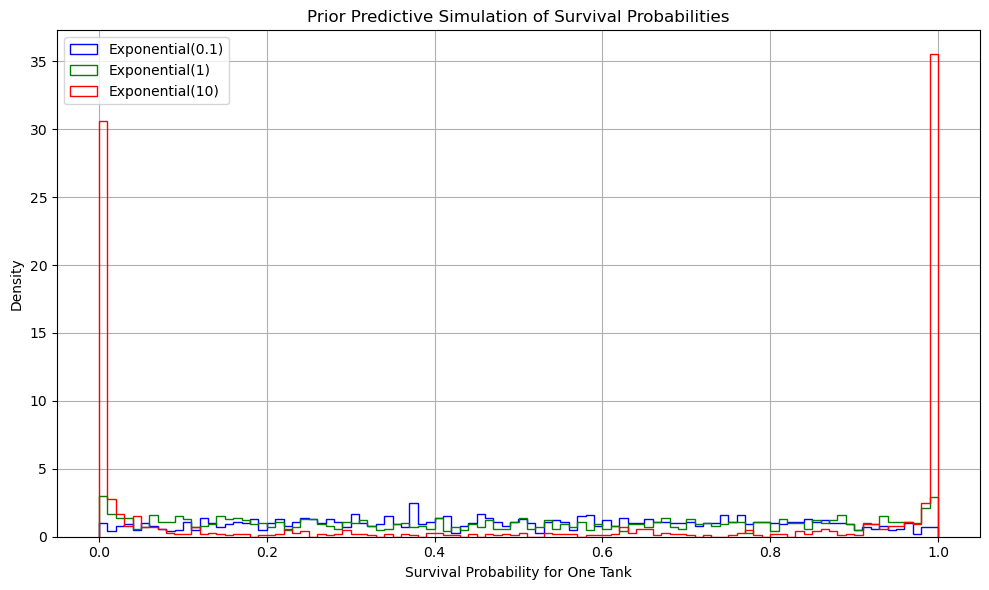

In [20]:
df = pd.read_csv("Data/reedfrogs.csv", sep=",")


a_bar = stats.norm.rvs(0,1, size=1000)

sigma_1 = stats.expon.rvs(0.1, size=1000)
sigma_2 = stats.expon.rvs(1, size=1000)
sigma_3 = stats.expon.rvs(10, size=1000)

alpha_1 = stats.norm.rvs(a_bar,sigma_1)
alpha_2 = stats.norm.rvs(a_bar,sigma_2)
alpha_3 = stats.norm.rvs(a_bar,sigma_3)

p1 = logistic(alpha_1)
p2 = logistic(alpha_2)
p3 = logistic(alpha_3)

plt.figure(figsize=(10, 6))
plt.hist(p1, bins=100, density=True, histtype="step", label="Exponential(0.1)", color='blue')
plt.hist(p2, bins=100, density=True, histtype="step", label="Exponential(1)", color='green')
plt.hist(p3, bins=100, density=True, histtype="step", label="Exponential(10)", color='red')

plt.xlabel("Survival Probability for One Tank")
plt.ylabel("Density")
plt.title("Prior Predictive Simulation of Survival Probabilities")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

How does increasing the width of the prior on $\sigma$ change the prior distribution of $\alpha_j$? **Limit your response to 4 sentences.** 

As the width of the prior increases, extreme probabilities at 0.0 and 1.0 are much more dense. Smaller prior widths are less dense and concentrated around the same density value at ~2.25 - ~2.5.  

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 2**. **(20 points)** Revisit the Reedfrog survival data, _Data/reedfrogs.csv_. The causal model (in the form of a DAG) considered in lecture, is provided in the image below. 

![](tank_survival_dag.png)

Beginning with the varying effects model from lecture that estimates the causal effect of the treatment *predation* on *survival*, consider how tadpole **size** (`size`) might modify the effect of **predation** (`pred`). The model from lecture also included a parameter for the tank effect. Your model must also **include this parameter**.

*Note:* A straightforward approach is to estimate an effect for _**each combination**_ of *predation* and *size*. **Use a 2-dimensional categorical index parameter to estimate the effects of each combination.** 

**No plots are needed for full credit for any part of this question**. 

In [46]:
df = pd.read_csv("Data/reedfrogs.csv")
p = np.where(df["pred"] == "pred", 1, 0)
s = np.where(df["size"] == "small", 0, 1)
# encode in 2 D space
combinations = (2 * s) + p
n_combinations = len(np.unique(combinations))
df["tank"] = np.arange(df.shape[0])
t = np.arange(df.shape[0])
n_t = df["tank"].nunique()

with pm.Model() as m_combo:
    s_a = pm.Exponential("s_a", 1.0)
    a = pm.Normal("a", 0.0, s_a, shape = n_t)
    b = pm.Normal("b", 0, 1, shape=n_combinations)
    logit = pm.math.invlogit(a[t] + b[combinations])
    S = pm.Binomial("S", n=df["density"].values, p=logit, observed=df["surv"].values)
    idata_combo = pm.sample(random_seed=42)
az.summary(idata_combo, var_names="b", hdi_prob=0.94)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [s_a, a, b]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[0],2.375,0.285,1.860,2.911,0.008,0.006,1334.0,1433.0,1.0
b[1],0.433,0.263,-0.080,0.898,0.009,0.007,797.0,1128.0,1.0
b[2],2.501,0.291,1.951,3.040,0.008,0.006,1244.0,1034.0,1.0
b[3],-0.420,0.254,-0.878,0.069,0.008,0.006,997.0,1087.0,1.0


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Answer the following question**: What do the estimates of the parameters for the combinations of *predation* and *size* imply about the influence of these combinations on tadpole survival? **Limit your response to 4 sentences.**

The survival chances of each combination of predation and size vary. Combinations where predation is low with either small or large size could have a higher survival rate than combinations with predation being high, and size being small. The estimates imply that predation has an influence on survival rate, and size of the tadpole could amplify that as well.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Now, approximate the posterior distribution of a **separate model** that considers the influence of the treatment variables individually (but within a single model). This __model will have distinct categorical index variables: one for *predation* and one for *size*__.  

In [48]:
n_p = len(np.unique(p))
n_s = len(np.unique(s))
with pm.Model() as m_sep:
    s_a = pm.Exponential("s_a", 1.0)  # tank variation
    a = pm.Normal("a", 0.0, s_a, shape=n_t)  # tank intercepts

    b_pred = pm.Normal("b_pred", 0, 1, shape=n_p)  
    b_size = pm.Normal("b_size", 0, 1, shape=n_s)  

    logit = pm.math.invlogit(a[t] + b_pred[p] + b_size[s])

    S = pm.Binomial("S", n=df["density"].values, p=logit, observed=df["surv"].values)

    idata_sep = pm.sample(random_seed=42)
    
az.summary(idata_sep, var_names=["b_pred", "b_size"],hdi_prob=0.94)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [s_a, a, b_pred, b_size]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_pred[0],1.939,0.553,0.866,2.918,0.020,0.014,785.0,1075.0,1.0
b_pred[1],-0.617,0.538,-1.624,0.353,0.020,0.015,761.0,962.0,1.0
b_size[0],0.904,0.541,-0.105,1.924,0.019,0.014,787.0,1118.0,1.0
b_size[1],0.405,0.549,-0.649,1.400,0.020,0.014,748.0,916.0,1.0


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Answer the following question**: Is there any information gained from the model which uses the treatment combinations that would be missed if only measuring the influences of *predation* and *size* seperately? **Limit your response to 5 sentences.**

*Note: It may be helpful to convert the posterior estimates to the probability scale using a logistic transformation when interpreting the results.* 

The model that includes the treatment combinations allows us to capture the interaction between predation and size, which shows the influence of a combination of factors on tadpole survival. The separate models only assess the separate effects of predation and size on survival, and doesn't consider how their combination might modify the survival rate.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 3**. **(16 points)** Now consider the causal effect of tank _density_ (the original number of tadpoles in the tank) on *survival* and perform the following steps:

1. Recreate the model with parameters for combinations of *predation* and *size* from Question 2 and add _density_ to your Binomial Generalized Linear Model (GLM) as a **standardized, continuous regression variable**.  
1. In this model, estimate a new, distinct parameter that measures the influence of *density* on survival **for each predation state**. This means the parameter that measures the influence of *density* on *survival* will be stratified by *predation* state. Be sure to **use the categorical index encoding approach** for this new parameter for full credit.   

In [53]:
density_std = standardize(df["density"])
with pm.Model() as m_c_d:
    sigma_a = pm.Exponential("sigma_a", 1)
    a = pm.Normal("a", mu=0, sigma=sigma_a, shape=n_t)
    b = pm.Normal("b", mu=0.0, sigma=1.0, shape=n_combinations)
    b_d = pm.Normal("b_d", mu=0.0, sigma=1.0, shape=n_p)
    logit = pm.math.invlogit(a[t] + b[combinations] + b_d[p] * density_std)
    S = pm.Binomial("S", n=df["density"], p=logit, observed=df["surv"])
    idata_c_d = pm.sample(random_seed=42)
    az.summary(idata_c_d, var_names=["b_d"])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_a, a, b, b_d]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


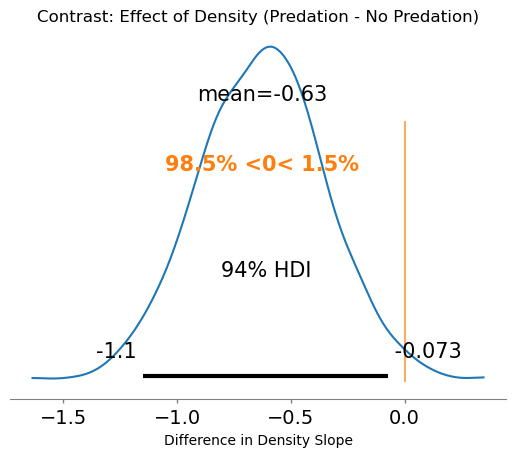

In [56]:
    diff = idata_c_d.posterior["b_d"]
    contrast = diff.sel(b_d_dim_0=1) - diff.sel(b_d_dim_0=0)
    az.plot_posterior(contrast, ref_val=0, hdi_prob=0.94)
    plt.title("Contrast: Effect of Density (Predation - No Predation)")
    plt.xlabel("Difference in Density Slope")
    plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

3. Comment on whether *predation* modifies the effect of *density* by computing, plotting, **and interpreting** the contrast distribution for the effect of *predation*.  **Limit your response to 4 sentences.**

The contrast between b_d[1] and b_d[0] is an average of -0.63, to demonstrate how the influence of the factors on survival rate. For examples where there is no predation present, density has an effect of 0.164, and -0.463 where predation is present. It is more dense where predation is low meaning survival rate is higher. Where predation is high, survival rate is lower. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

4. Create a plot that includes the posterior distribution for $\sigma$ (the population-level tank standard deviation) in this model and the posterior distribution for $\sigma$ from Question 2's *predation/size* combination model. This will be a single plot with two separate distributions.

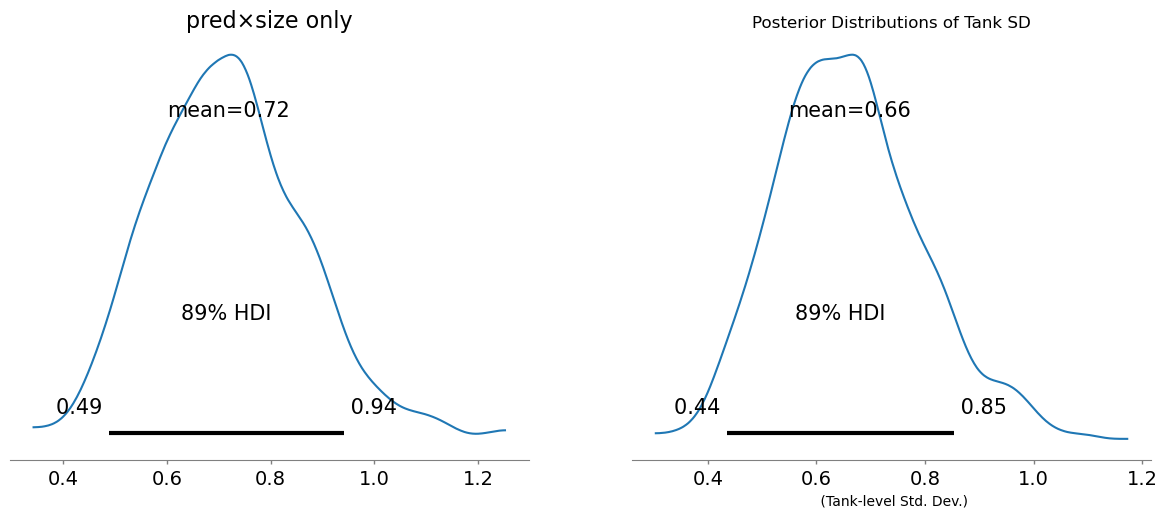

In [61]:
s_2 = idata_combo.posterior["s_a"]
s_3 = idata_c_d.posterior["sigma_a"]
az.plot_posterior(
 {"Combinations of Predation and Size": s_2, "Density w/ Predation": s_3},
 hdi_prob=0.89,
point_estimate="mean"
)
plt.title("Posterior Distributions of Tank SD")
plt.xlabel(" (Tank-level Std. Dev.)") 
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

How are the distributions of the $\sigma$ parameters different? Why? **Limit your response to 8 sentences.**

_Type your answer here, replacing this text._

In [ ]:
grader.check("q3.3")

<!-- END QUESTION -->



## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Before attempting to export your work for submission follow this process: First, make sure you have run all cells in your notebook **in order**. Then, **save your notebook**. Finally, run the export cell below. This sequence of actions will ensure that all code/output/plots appear in the generated PDF. **Only the PDF** will be evaluated for grading purposes.  When executed, the cell below will generate a zip file for you to submit.

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)